In [1]:
# if our large test file is available, use it. Otherwise, use file generated from toy_mstis_2_run.ipynb
import os
test_file = "../toy_mstis_1k_OPS1.nc"
filename = test_file if os.path.isfile(test_file) else "mstis.nc"
print 'Using file `%s` for analysis' % filename

Using file `../toy_mstis_1k_OPS1.nc` for analysis


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpathsampling as paths
import pandas as pd

# TIS Analysis Framework Examples

This notebook provides an overview of the TIS analysis framework in OpenPathSampling. We start with the `StandardTISAnalysis` object, which will probably meet the needs of most users. Then we go into details of how to set up custom objects for analysis, and how to assemble them into a generic `TISAnalysis` object.

In [3]:
%%time
storage = paths.AnalysisStorage(filename)

CPU times: user 4.88 s, sys: 359 ms, total: 5.24 s
Wall time: 5.8 s


In [4]:
network = storage.networks[0]
scheme = storage.schemes[0]

In [5]:
stateA = storage.volumes['A']
stateB = storage.volumes['B']
stateC = storage.volumes['C']
all_states = [stateA, stateB, stateC]  # all_states gives the ordering

# Simplified Combined Analysis

The `StandardTISAnalysis` object makes it very easy to perform the main TIS rate analysis. Furthermore, it caches all the intemediate results, so they can also be analyzed.

In [6]:
from openpathsampling.analysis.tis import StandardTISAnalysis

In [7]:
# the scheme is only required if using the minus move for the flux
tis_analysis = StandardTISAnalysis(
    network=network,
    scheme=scheme,
    max_lambda_calcs={t: {'bin_width': 0.05, 'bin_range': (0.0, 0.5)}
                      for t in network.sampling_transitions}
)

In [8]:
%%time
tis_analysis.rate_matrix(steps=storage.steps).to_pandas(order=all_states)

/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:336: RuntimeWarning: invalid value encountered in divide
  addends_k = np.divide(numerator_byQ, sum_over_Z_byQ)


CPU times: user 14.3 s, sys: 339 ms, total: 14.6 s
Wall time: 16.7 s


/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:409: RuntimeWarning: invalid value encountered in double_scalars
  output[val] = sum_k_Hk_Q[val] / sum_w_over_Z


,A,B,C
A,NaN,3.20995e-05,0.000101309
B,0.00103954,NaN,0.000586511
C,2.12203e-05,0,NaN


Note that there are many options for setting up the `StandardTISAnalysis` object. Most customizationizations to the analysis can be performed by changing the initialization parameters of that object; see its documentation for details.

## Looking at the parts of the calculation

Once you run the rate calculation (or if you run `tis_analysis.calculate(steps)`, you have already cached a large number of subcalculations. All of those are available in the `results` dictionary, although the analysis object has a number of conveniences to access some of them.

Looking at the keys of the results dictionary, we can see what has been cached:

In [9]:
tis_analysis.results.keys()

['max_lambda',
 'conditional_transition_probability',
 'flux',
 'rate',
 'total_crossing_probability',
 'transition_probability']

In practice, however, we won't go directly to the results dictionary. We'd rather use the convenience methods that make it easier to get to the interesting results.

We'll start by looking at the flux:

In [10]:
tis_analysis.flux_matrix

{(<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>,
  <openpathsampling.volume.CVDefinedVolume at 0x10ba24710>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190d10>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190e10>): 0.027932960893854747}

Next we look at the total crossing probability (i.e., the crossing probability, joined by WHAM) for each sampled transition. We could also look at this per physical transition, but of course $A\to B$ and $A\to C$ are identical in MSTIS -- only the initial state matters.

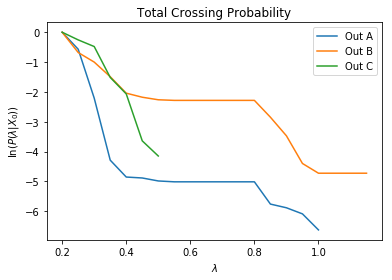

In [11]:
for transition in network.sampling_transitions:
    label = transition.name
    tcp = tis_analysis.total_crossing_probability[transition]
    plt.plot(tcp.x, np.log(tcp), label=label)
plt.title("Total Crossing Probability")
plt.xlabel("$\lambda$")
plt.ylabel("$\ln(P(\lambda | X_0))$")
plt.legend();

We may want to look in more detail at one of these, by checking the per-ensemble crossing probability (as well at the total crossing probability). Here we select based on the $A\to B$ transition, we would get the same results if we selected the transition using either `trans = network.from_state[stateA]` or `trans = network.transitions[(stateA, stateC)]`.

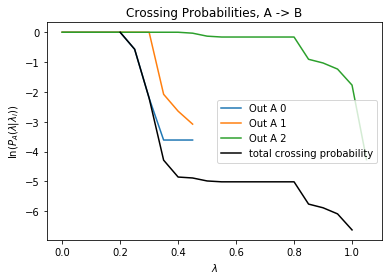

In [12]:
state_pair = (stateA, stateB)
trans = network.transitions[state_pair]
for ens in trans.ensembles:
    crossing = tis_analysis.crossing_probability(ens)
    label = ens.name
    plt.plot(crossing.x, np.log(crossing), label=label)
tcp = tis_analysis.total_crossing_probability[state_pair]
plt.plot(tcp.x, np.log(tcp), '-k', label="total crossing probability")
plt.title("Crossing Probabilities, " + stateA.name + " -> " + stateB.name)
plt.xlabel("$\lambda$")
plt.ylabel("$\ln(P_A(\lambda | \lambda_i))$")
plt.legend();

Finally, we look at the last part of the rate calculation: the conditional transition probability. This is calculated for the outermost interface in each interface set.

In [13]:
tis_analysis.conditional_transition_probability

,A,B,C
Out B 2,0.514,0.196,0.290
Out A 2,0.148,0.205,0.647
Out C 2,0.006,NaN,0.994


# Individual components of the analysis

The combined analysis is the easiest way to perform analysis, but if you need to customize things (or if you want to compare different calculation methods) you might want to create objects for components of the analysis individually. Note that unlike the `StandardTISAnalysis` object, these do not cache their intermediate results.

## Flux from the minus move

In [14]:
from openpathsampling.analysis.tis import MinusMoveFlux

In [15]:
flux_calc = MinusMoveFlux(scheme)

To calculate the fluxes, we use the `.calculate` method of the `MinusMoveFlux` object:

In [16]:
%%time
fluxes = flux_calc.calculate(storage.steps)

CPU times: user 11.5 s, sys: 227 ms, total: 11.7 s
Wall time: 14 s


In [17]:
fluxes

{(<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>,
  <openpathsampling.volume.CVDefinedVolume at 0x10ba24710>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190d10>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190e10>): 0.027932960893854747}

The minus move flux calculates some intermediate information along the way, which can be of use for further analysis. This is cached when using the `StandardTISAnalysis`, but can always be recalculated. The intermediate maps each `(state, interface)` pair to a dictionary. For details on the structure of that dictionary, see the documentation of `TrajectoryTransitionAnalysis.analyze_flux`.

In [18]:
%%time
flux_dicts = flux_calc.intermediates(storage.steps)[0]

CPU times: user 10.7 s, sys: 162 ms, total: 10.9 s
Wall time: 11.4 s


In [19]:
flux_dicts

{(<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>,
  <openpathsampling.volume.CVDefinedVolume at 0x10ba24710>): {'in': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentContainer at 0x1184a4f50>,
  'out': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentContainer at 0x1184a4dd0>},
 (<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190d10>): {'in': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentContainer at 0x118820e10>,
  'out': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentContainer at 0x118820bd0>},
 (<openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190e10>): {'in': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentContainer at 0x1182867d0>,
  'out': <openpathsampling.analysis.trajectory_transition_analysis.TrajectorySegmentCo

## Flux from existing dictionary

The `DictFlux` class (which is required for MISTIS, and often provides better statistics than the minus move flux in other cases) takes a pre-calculated flux dictionary for initialization, and always returns that dictionary. The dictionary is in the same format as the `fluxes` returned by the `MinusMoveFlux.calculate` method; here, we'll just use the results we calculated above:

In [20]:
from openpathsampling.analysis.tis import DictFlux

In [21]:
dict_flux = DictFlux(fluxes)

In [22]:
dict_flux.calculate(storage.steps)

{(<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>,
  <openpathsampling.volume.CVDefinedVolume at 0x10ba24710>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190d10>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190e10>): 0.027932960893854747}

Note that `DictFlux.calculate` just echoes back the dictionary we gave it, so it doesn't actually care if we give it the steps argument or not:

In [23]:
dict_flux.calculate(None)

{(<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>,
  <openpathsampling.volume.CVDefinedVolume at 0x10ba24710>): 0.015579020252726327,
 (<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190d10>): 0.020049008687903762,
 (<openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>,
  <openpathsampling.volume.CVDefinedVolume at 0x115190e10>): 0.027932960893854747}

This object can be used to provide the flux part of the TIS calculation, in exactly the same way a `MinusMoveFlux` object does.

## Total crossing probability function

To calculate the total crossing probability, we must first calculate the individual ensemble crossing probabilities. This is done by creating a histogram of the maximum values of the order parameter. The class to do that is  `FullHistogramMaxLambdas`. Then we'll create the `TotalCrossingProbability`.

In [24]:
transition = network.sampling_transitions[0]

In [25]:
print transition

TISTransition: Out A
A -> A or all states except A
Interface: 0.0<opA<0.2
Interface: 0.0<opA<0.3
Interface: 0.0<opA<0.4



In [26]:
from openpathsampling.analysis.tis import FullHistogramMaxLambdas, TotalCrossingProbability
from openpathsampling.numerics import WHAM

In [27]:
max_lambda_calc = FullHistogramMaxLambdas(
    transition=transition,
    hist_parameters={'bin_width': 0.05, 'bin_range': (0.0, 0.5)}
)

We can also change the function used to calculate the maximum value of the order parameter with the `max_lambda_func` parameter. This can be useful to calculate the crossing probabilities along some other order parameter.

To calculate the total crossing probability function, we also need a method for combining the ensemble crossing probability functions. We'll use the default WHAM here; see its documentation for details on how it can be customized.

In [28]:
combiner = WHAM(interfaces=transition.interfaces.lambdas)

Now we can put these together into the total crossing probability function:

In [29]:
total_crossing = TotalCrossingProbability(
    max_lambda_calc=max_lambda_calc,
    combiner=combiner
)

In [30]:
tcp = total_crossing.calculate(storage.steps)

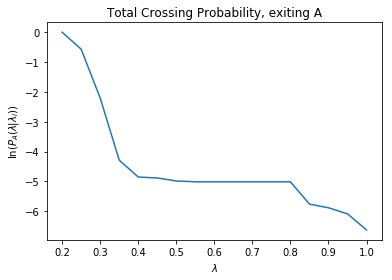

In [31]:
plt.plot(tcp.x, np.log(tcp))

plt.title("Total Crossing Probability, exiting " + transition.stateA.name)
plt.xlabel("$\lambda$")
plt.ylabel("$\ln(P_A(\lambda | \lambda_i))$")

## Conditional transition probability

The last part of the standard calculation is the conditional transition probability. We'll make a version of this that works for all ensembles:

In [32]:
from openpathsampling.analysis.tis import ConditionalTransitionProbability

In [33]:
outermost_ensembles = [trans.ensembles[-1] for trans in network.sampling_transitions]

In [34]:
cond_transition = ConditionalTransitionProbability(
    ensembles=outermost_ensembles,
    states=network.states
)

In [35]:
ctp = cond_transition.calculate(storage.steps)

In [36]:
ctp

{<openpathsampling.ensemble.TISEnsemble at 0x1169f7590>: {<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>: 0.196,
  <openpathsampling.volume.CVDefinedVolume at 0x114ff6510>: 0.514,
  <openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>: 0.29},
 <openpathsampling.ensemble.TISEnsemble at 0x1171e5890>: {<openpathsampling.volume.CVDefinedVolume at 0x10ba24690>: 0.205,
  <openpathsampling.volume.CVDefinedVolume at 0x114ff6510>: 0.148,
  <openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>: 0.647},
 <openpathsampling.ensemble.TISEnsemble at 0x1171ee950>: {<openpathsampling.volume.CVDefinedVolume at 0x114ff6510>: 0.006,
  <openpathsampling.volume.CVDefinedVolume at 0x11518bdd0>: 0.994}}

`StandardTISAnalysis.conditional_transition_probability` converts this into a `pandas.DataFrame`, which gives prettier printing. However, the same data in included in this dict-of-dict structure.

# Assembling a TIS analysis from scratch

If you're using the "standard" TIS approach, then the `StandardTISAnalysis` object is the most efficient way to do it. However, if you want to use another analysis approach, it can be useful to see how the "standard" approach can be assembled.

This won't have all the shortcuts or saved intermediates that the specialized object does, but it will use the same algorithms to get the same results.

In [37]:
from openpathsampling.analysis.tis import StandardTransitionProbability, TISAnalysis

Some of the objects that we created in previous sections can be reused here. In particular, there is only only one flux calculation and only one conditional transitional transition probability per reaction network. However, the total crossing probability method is dependent on the transition (different order parameters might have different histrogram parameters). So we need to associate each transition with a different `TotalCrossingProbability` object. In this example, we take the default behavior of WHAM (instead of specifying in explicitly, as above).

In [38]:
tcp_methods = {
    trans: TotalCrossingProbability(
        max_lambda_calc=FullHistogramMaxLambdas(
            transition=trans,
            hist_parameters={'bin_width': 0.05, 'bin_range': (0.0, 0.5)}
        )
    )
    for trans in network.transitions.values()
}

The general `TISAnalysis` object makes the most simple splitting: flux and transition probability. A single flux calculation is used for all transitions, but each transition has a different transition probability (since each transition can have a different total crossing probability). We make those objects here.

In [39]:
transition_probability_methods = {
    trans: StandardTransitionProbability(
        transition=trans,
        tcp_method=tcp_methods[trans],
        ctp_method=cond_transition
    )
    for trans in network.transitions.values()
}

Finally we put this all together into a `TISAnalysis` object, and calculate the rate matrix.

In [40]:
analysis = TISAnalysis(
    network=network,
    flux_method=dict_flux,
    transition_probability_methods=transition_probability_methods
)

In [41]:
analysis.rate_matrix(storage.steps)

             A            B            C
A          NaN  3.20995e-05  0.000101309
B   0.00103954          NaN  0.000586511
C  2.12203e-05            0          NaN

This is the same rate matrix as we obtained with the `StandardTISAnalysis`. It is a little faster because we used the precalculated `DictFlux` object in this instead of the `MinusMoveFlux`, otherwise this would be slower.